<a href="https://colab.research.google.com/github/YaninaK/car-insurance-renewal/blob/main/notebooks/01_Car_insurance_renewal_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз пролонгации полиса автострахования.

## EDA и генерация новых признаков

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders -q

In [3]:
import pandas as pd
import numpy as np
import category_encoders as ce

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
PATH = '/content/drive/MyDrive/ML_projects/04_Car_insurance_renewal/data/01_raw/'

## 1. Чтение данных

In [6]:
data_file = 'Задание (пролонгация).xlsx'
field_description = pd.read_excel(
    PATH + data_file, 0, header=None
)
data = pd.read_excel(PATH + data_file, 1)

In [7]:
field_description

,0,1
0,id,ID договора
1,Filial,Филиал продажи
2,Type_ts,Тип ТС
3,passport_region,Регион по серии паспорта
4,VIP,VIP клиент
5,Brand,Марка ТС
6,Model,Модель ТС
7,Yr_production,Год выпуска ТС
8,GAP,GAP застрахован
9,married,Брак


In [8]:
print(f'data.shape = {data.shape}\n')
data.sample(5)

data.shape = (10863, 30)



,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
3063,3064,Уфимский,Отечественные,Республика Башкортостан,NaN,CHEVROLET,NIVA,2018,Нет,Состоит в браке,...,47,21,1.00,400000,M,0,10000,0.000,0,0
6449,6450,Санкт - Петербургский,Отечественные,Санкт-Петербург,NaN,LADA,VESTA,2016,Нет,Состоит в браке,...,41,20,1.05,400000,F,0,20000,0.040,1,1
1237,1238,Санкт - Петербургский,Иностранные,Санкт-Петербург,NaN,VOLKSWAGEN,POLO,2018,Нет,Не состоит в браке,...,38,12,1.00,600000,M,0,25000,0.035,0,0
2440,2441,Нижегородский,Иностранные,Нижегородская область,NaN,HYUNDAI,SOLARIS,2017,Нет,Состоит в браке,...,45,8,1.00,600000,M,0,10000,0.015,1,1
4671,4672,Санкт - Петербургский,Иностранные,Санкт-Петербург,NaN,VOLKSWAGEN,TIGUAN,2016,Да,Состоит в браке,...,46,26,1.00,1000000,M,0,30000,0.025,0,1


In [9]:
TARGET_NAME = 'target'

## 2. Разделение на обучающую и тестовую выбоки

In [10]:
train = data[data[TARGET_NAME] != -1]
train.shape

(7598, 30)

In [11]:
test = data[data[TARGET_NAME] == -1]
test.shape

(3265, 30)

## 3. Распределение целевой переменной

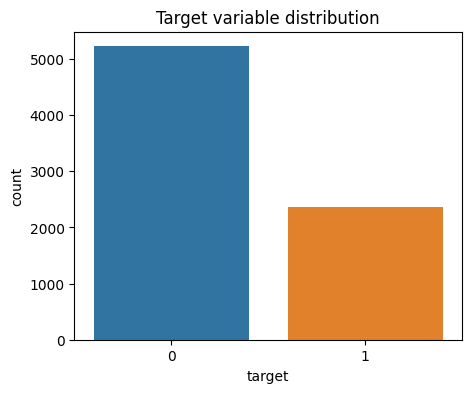

In [12]:
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET_NAME, data=train)
plt.title('Target variable distribution')
plt.show()

## 4. Числовые переменные

In [13]:
numeric_variables = (
    train.dtypes[train.dtypes != 'object']
    .drop(['ID', TARGET_NAME], axis=0)
    .index.tolist()
)
train[numeric_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
Yr_production,7598.0,2016.938668,1.549814,2009.0,2016.00,2018.00,2018.000,2018.0
KBM,7598.0,7.054488,1.924036,0.0,6.00,8.00,8.000,12.0
KBM_prol_est,7598.0,5.187418,1.732967,0.0,5.00,6.00,6.000,10.0
delta_kbm,7598.0,-5.065280,17.259945,-100.0,-2.00,-2.00,-2.000,2.0
Age,7598.0,43.727297,11.310642,18.0,35.00,42.00,52.000,83.0
Exp,7598.0,17.226375,9.653962,0.0,10.00,16.00,22.000,63.0
discount,7598.0,1.000559,0.050292,0.9,1.00,1.00,1.000,1.1
Amount - gr,7598.0,979626.217426,682881.387503,0.0,600000.00,800000.00,1200000.000,3000000.0
premium_car,7598.0,0.088576,0.284149,0.0,0.00,0.00,0.000,1.0
price_gr,7598.0,32769.807844,19740.598921,10000.0,15000.00,30000.00,45000.000,70000.0


In [14]:
numeric_info = train[numeric_variables].nunique()
numeric_info

Yr_production    10
KBM              13
KBM_prol_est     11
delta_kbm         6
Age              65
Exp              57
discount          5
Amount - gr      16
premium_car       2
price_gr         13
price_prc        21
OSAGO_clnt        2
dtype: int64

### 4.1. Корреляция числовых признаков

In [15]:
def get_correlated_features(df, numeric_variables, threshold=0.95):
  corr = df[numeric_variables].corr()
  for i in range(len(numeric_variables)):
    for j in range(i + 1, len(numeric_variables)):
      if abs(corr.iloc[i, j]) > threshold:
        corr_ = round(corr.iloc[i, j], 2)
        print(corr_, numeric_variables[i], numeric_variables[j])

* корреляция с целевой переменной

In [16]:
corr = train[[TARGET_NAME] + numeric_variables].corr()[[TARGET_NAME]]
ind = abs(corr).sort_values(by=TARGET_NAME, ascending=False).index
corr.loc[ind, :]

,target
target,1.000000
KBM,-0.252335
KBM_prol_est,-0.251851
Yr_production,-0.215995
price_prc,-0.133185
delta_kbm,-0.122458
OSAGO_clnt,0.081035
Age,0.075386
premium_car,0.070872
price_gr,-0.059282


* числовые признаки с высокой корреляцией

In [17]:
get_correlated_features(train, numeric_variables, 0.8)

0.97 KBM KBM_prol_est


In [18]:
train.drop('KBM_prol_est', axis=1, inplace=True)

Признак KBM_prol_est удалим.

### 4.2. Трансформация числовых признаков

In [19]:
def plot_var(var):
  plt.plot(train.groupby(var).mean()[TARGET_NAME])
  plt.xlabel(var)
  plt.ylabel(f'Mean {TARGET_NAME}')
  plt.title(f'{var} vs {TARGET_NAME}');

#### KBM

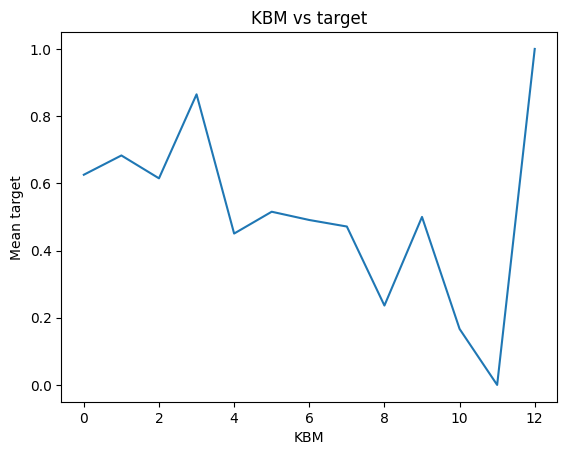

In [20]:
plot_var('KBM')

In [21]:
train['KBM'].value_counts()

8     5536
6      929
4      424
0      243
7      140
2      135
5       97
1       41
3       37
9        8
10       6
12       1
11       1
Name: KBM, dtype: int64

In [22]:
train['KBM'] = np.where(train['KBM'] >= 8, 8, train['KBM'])
train['KBM_1'] = np.where(train['KBM'] <= 3, train['KBM'], 0)
train['KBM_2'] = np.where(train['KBM'] > 3, train['KBM'], 0)

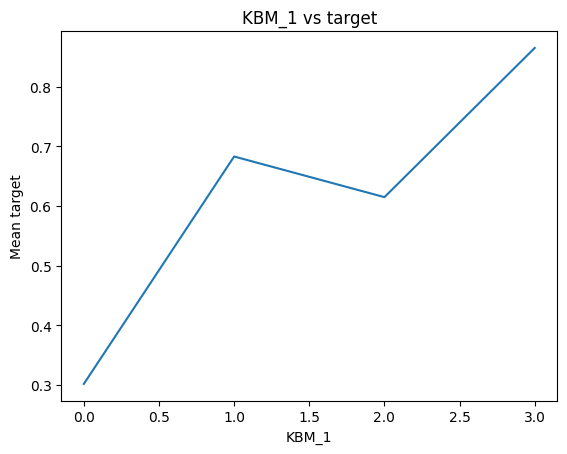

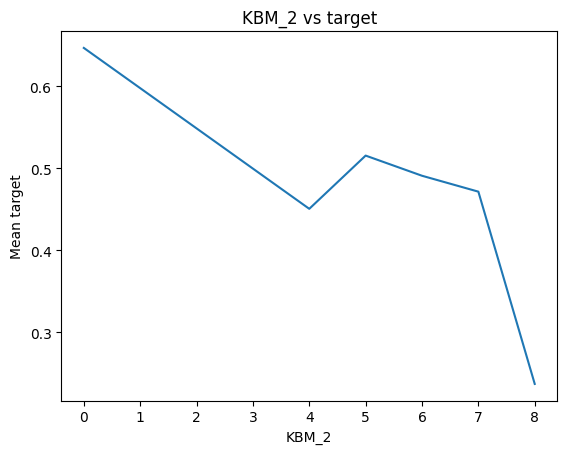

In [23]:
for var in ['KBM_1', 'KBM_2']:
  plt.figure()
  plot_var(var);

In [24]:
train.drop('KBM', axis=1, inplace=True)

#### Yr_production

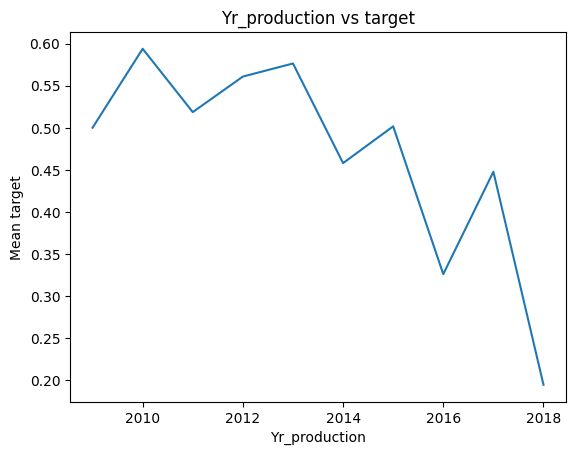

In [25]:
plot_var('Yr_production')

In [26]:
train['Yr_production'].value_counts()

2018    3861
2017    1796
2016     951
2015     315
2014     297
2013     177
2012     107
2011      54
2010      32
2009       8
Name: Yr_production, dtype: int64

#### price_prc

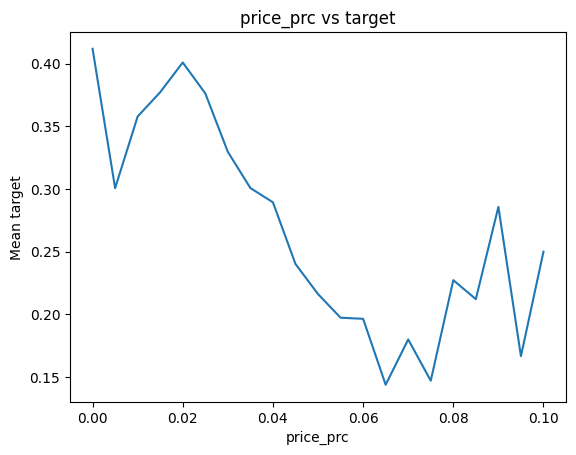

In [27]:
plot_var('price_prc')

In [28]:
train['price_prc'].value_counts()

0.030    974
0.020    958
0.025    949
0.035    848
0.040    712
0.015    639
0.045    508
0.010    436
0.050    421
0.055    299
0.060    224
0.005    163
0.065    146
0.070    100
0.075     68
0.080     44
0.085     33
0.090     21
0.100     20
0.095     18
0.000     17
Name: price_prc, dtype: int64

In [29]:
train['price_prc'] = np.where(
    train['price_prc'] <= 0.005, 0.005, train['price_prc']
)
train['price_prc'] = np.where(
    train['price_prc'] >= 0.075, 0.075, train['price_prc']
)
bins = [
    0, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.075
]
train['price_prc'] = pd.cut(train['price_prc'], bins, labels=bins[1:])

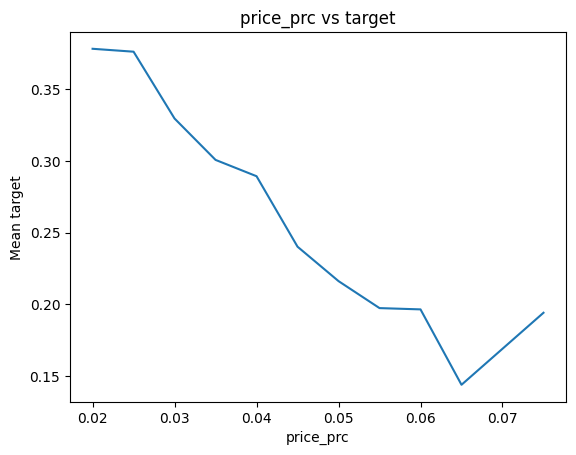

In [30]:
plot_var('price_prc')

#### delta_kbm

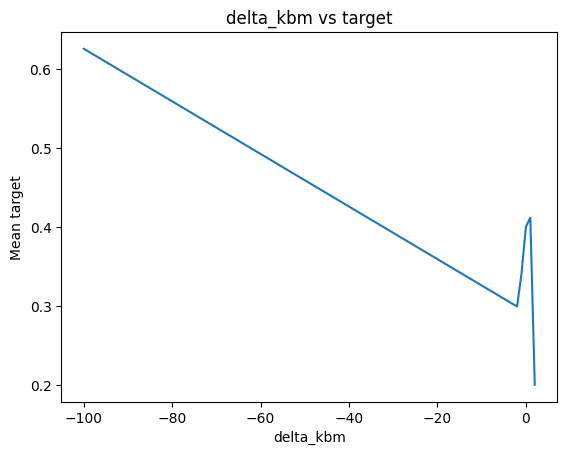

In [31]:
plot_var('delta_kbm')

In [32]:
train['delta_kbm'].value_counts()

-2      6924
-1       382
-100     243
 1        34
 0        10
 2         5
Name: delta_kbm, dtype: int64

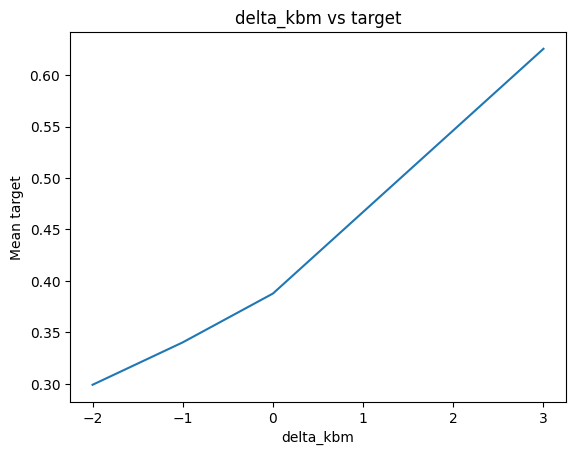

In [33]:
train['delta_kbm'] = np.where(train['delta_kbm'] < 0, train['delta_kbm'], 0)
train['delta_kbm'] = np.where(train['delta_kbm'] == -100, 3, train['delta_kbm'])
plot_var('delta_kbm')

#### OSAGO_clnt

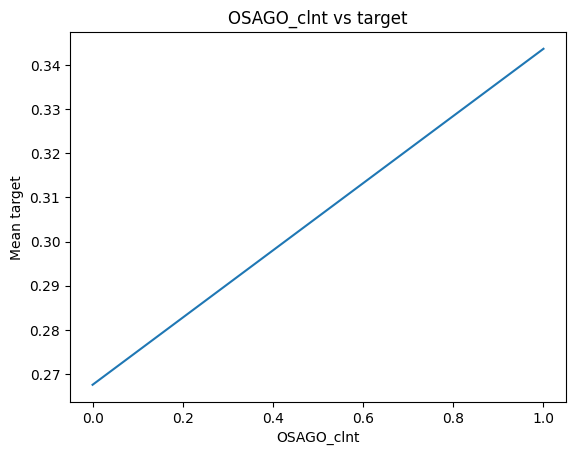

In [34]:
plot_var('OSAGO_clnt')

In [35]:
train['OSAGO_clnt'].value_counts()

1    4454
0    3144
Name: OSAGO_clnt, dtype: int64

#### Age

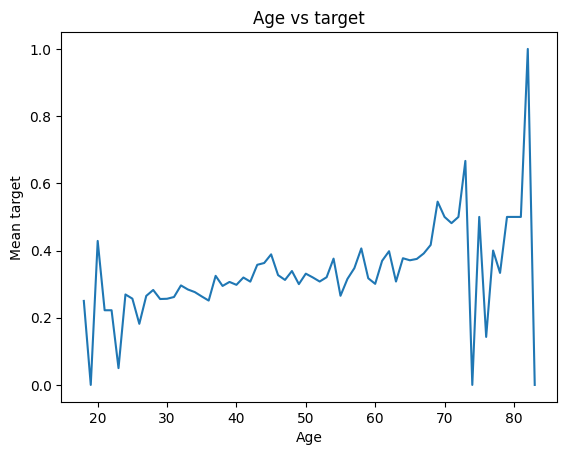

In [36]:
plot_var('Age')

In [37]:
train['Age'].value_counts().tail(20)

71    27
24    26
23    20
70    18
72    14
21     9
22     9
20     7
76     7
78     6
77     5
79     4
18     4
75     4
74     3
73     3
83     2
19     2
81     2
82     1
Name: Age, dtype: int64

In [38]:
train['Age'] = np.where(train['Age'] <= 27, 27, train['Age'])
train['Age'] = np.where(train['Age'] >= 65, 65, train['Age'])

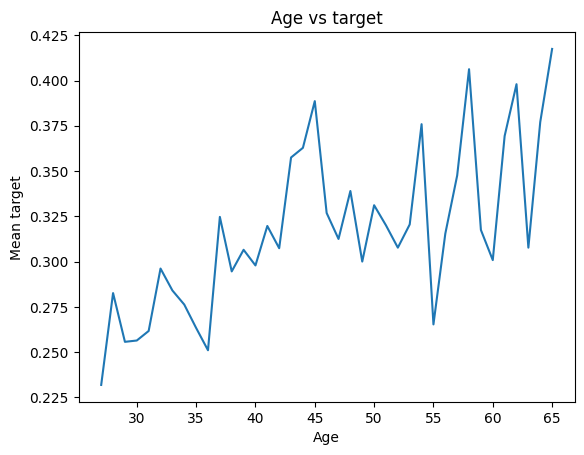

In [39]:
plot_var('Age')

#### premium_car

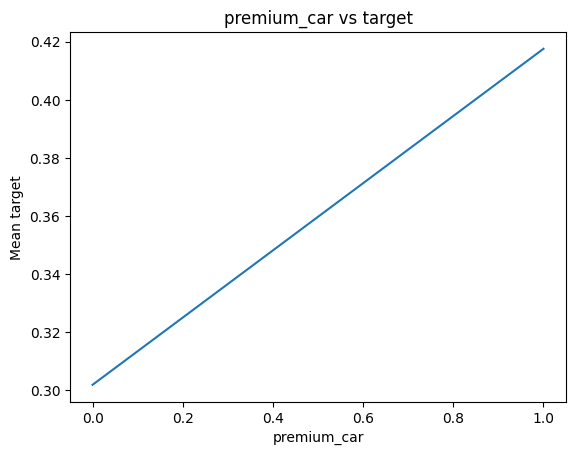

In [40]:
plot_var('premium_car')

In [41]:
train['premium_car'].value_counts()

0    6925
1     673
Name: premium_car, dtype: int64

#### price_gr

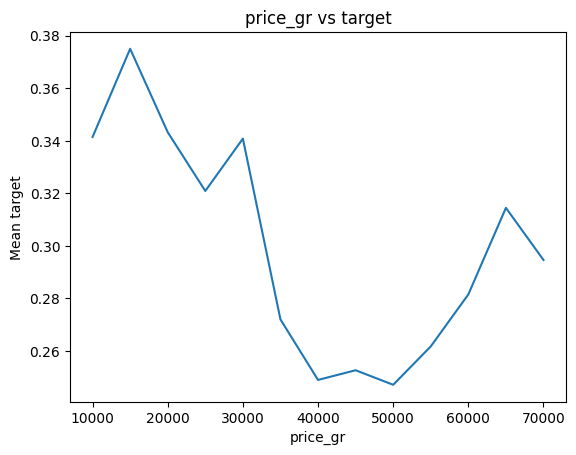

In [42]:
plot_var('price_gr')

In [43]:
train['price_gr'].value_counts()

10000    1523
70000     818
25000     723
15000     704
20000     673
30000     669
35000     625
40000     486
45000     376
50000     348
55000     256
60000     238
65000     159
Name: price_gr, dtype: int64

In [44]:
train['price_gr_1'] = np.where(train['price_gr'] < 1.5e4, 1, 0)
train['price_gr_2'] = np.where(
    (train['price_gr'] >= 1.5e4) & (train['price_gr'] <= 4e4), train['price_gr'], np.nan
)
bins = [4e4,  5e4, 5.5e4, 6e4, 7e4]
train['price_gr_3'] = pd.cut(train['price_gr'], bins, labels=bins[1:])

train.drop('price_gr', axis=1, inplace=True)

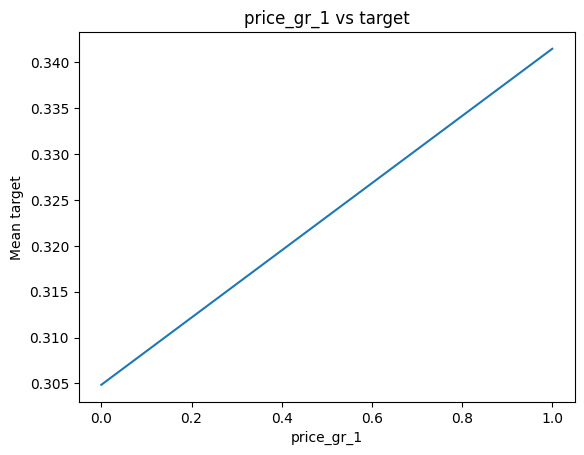

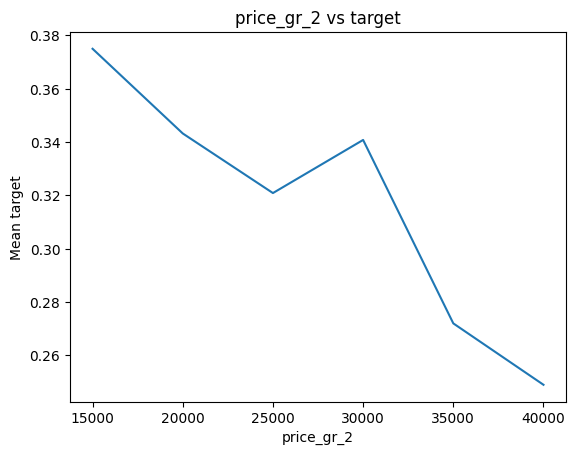

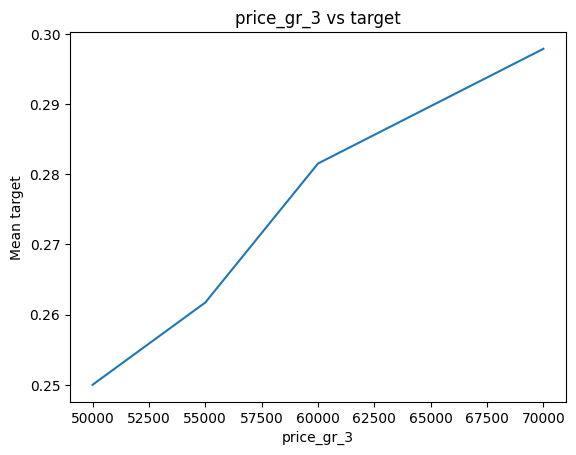

In [45]:
for var in ['price_gr_1', 'price_gr_2', 'price_gr_3']:
  plt.figure()
  plot_var(var)

#### Exp

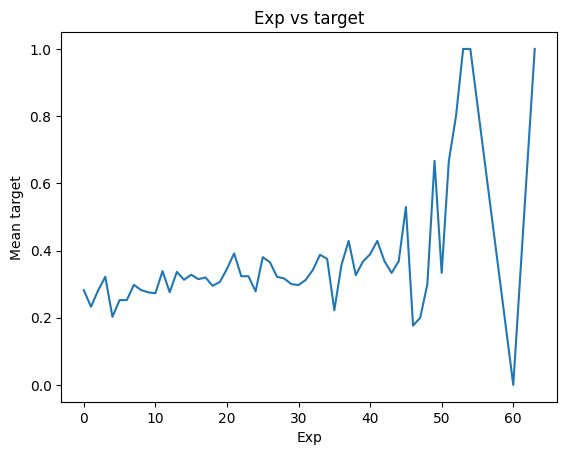

In [46]:
plot_var('Exp')

In [47]:
train['Exp'].value_counts().tail(20)

39    49
38    49
1     43
0     39
42    38
41    35
43    21
44    19
46    17
45    17
48    10
47    10
52     5
51     3
50     3
49     3
60     2
53     1
63     1
54     1
Name: Exp, dtype: int64

In [48]:
train['Exp'] = np.where(train['Exp'] >=45, 45,  train['Exp'])

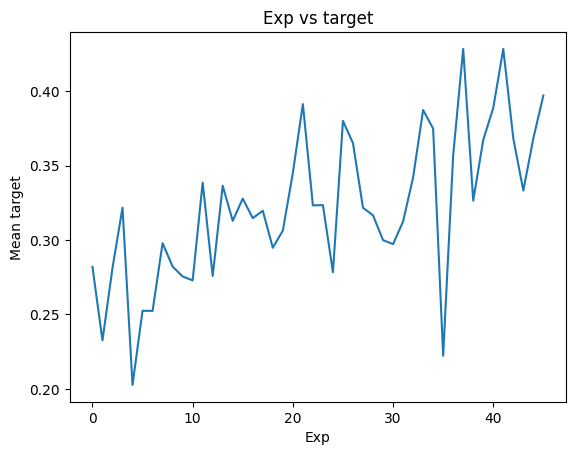

In [49]:
plot_var('Exp')

#### Amount - gr

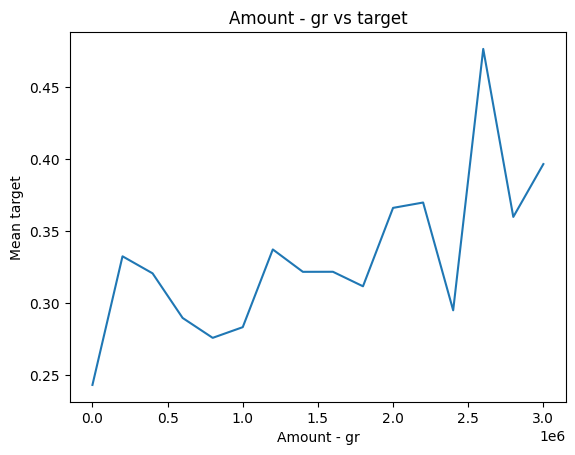

In [50]:
plot_var('Amount - gr')

In [51]:
train['Amount - gr'].value_counts()

600000     1615
400000     1328
800000     1098
1000000     674
1400000     522
1200000     492
200000      475
1600000     320
3000000     305
1800000     263
2000000     172
2200000     100
2600000      86
2400000      61
2800000      50
0            37
Name: Amount - gr, dtype: int64

#### discount

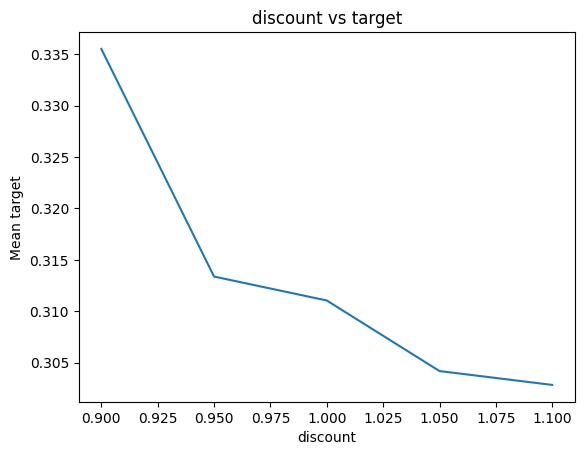

In [52]:
plot_var('discount')

In [53]:
train['discount'].value_counts()

1.00    4546
1.05     789
1.10     776
0.90     769
0.95     718
Name: discount, dtype: int64

### 4.3. Распределение числовых признаков.

In [54]:
def plot_numeric_variable(train, feature, figsize=(6, 3)):
    var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
    var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

    plt.figure(figsize=figsize)
    plt.hist(var_target_0, density=True, alpha=0.5, label='No renewal')
    plt.hist(var_target_1, density=True, alpha=0.5, label='Renewal')
    plt.title(feature)
    plt.legend();

In [55]:
numeric_variables = (
    train.dtypes[train.dtypes != 'object']
    .drop(['ID', TARGET_NAME], axis=0)
    .index.tolist()
)

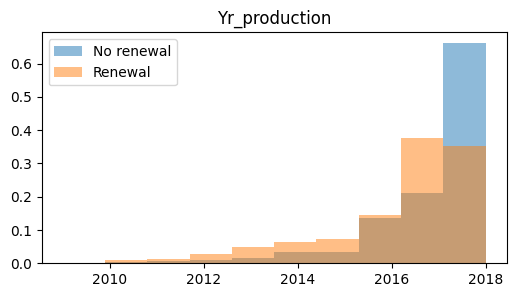

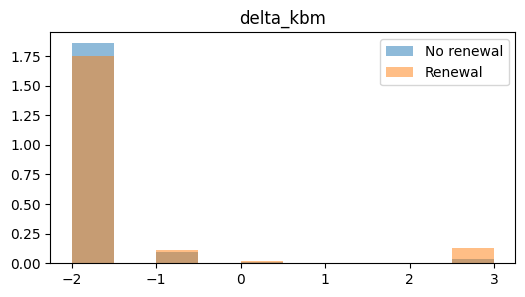

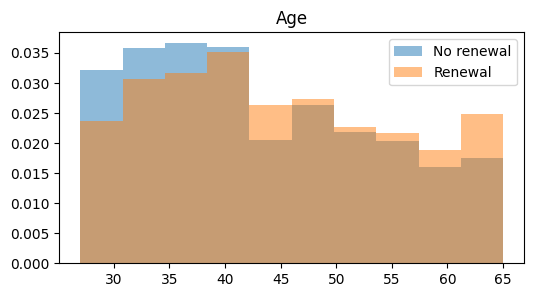

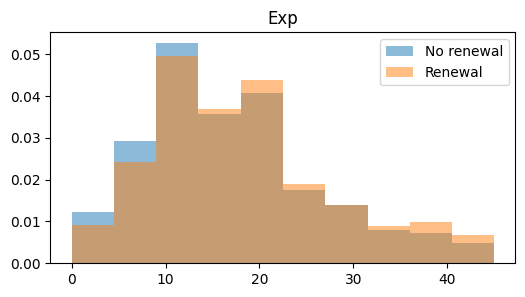

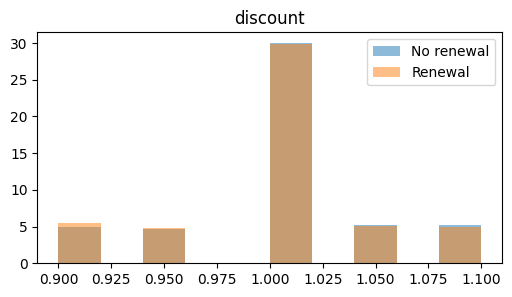

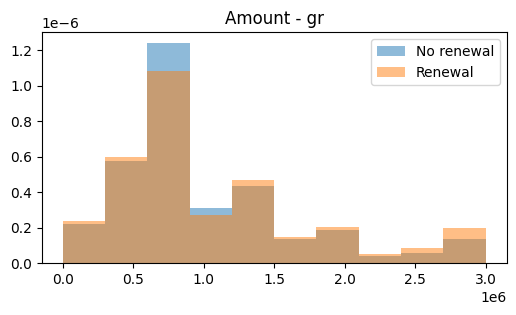

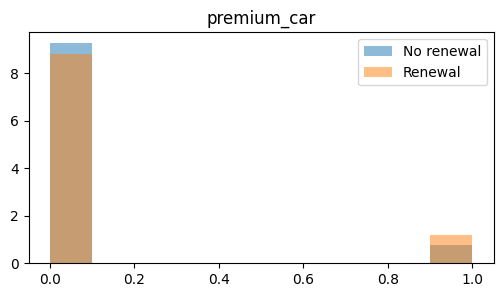

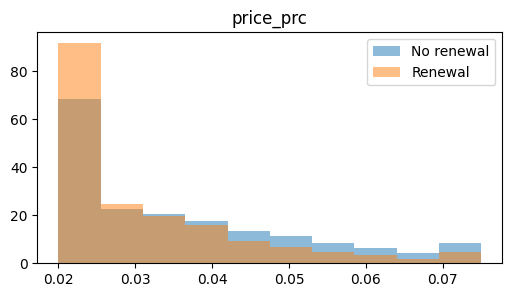

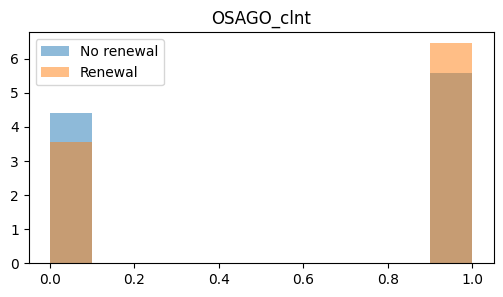

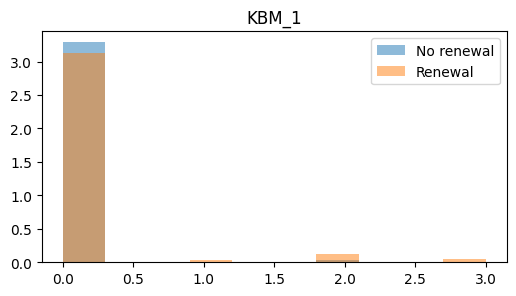

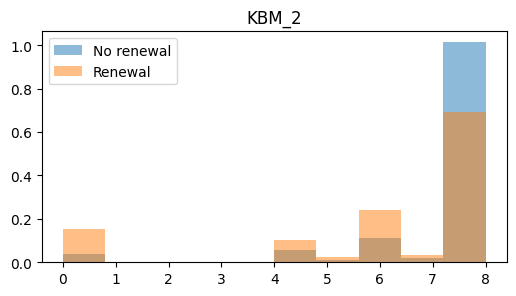

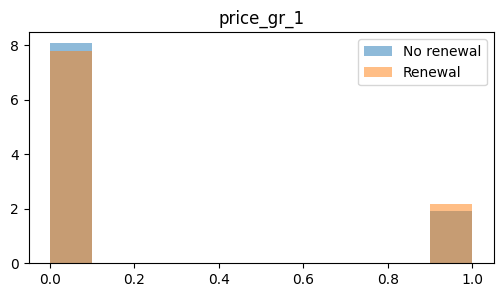

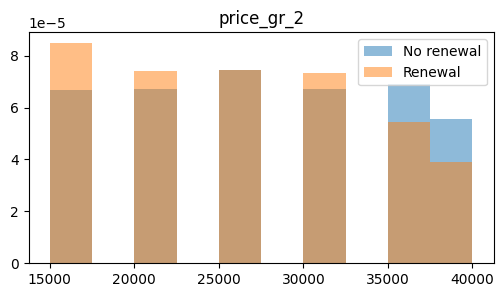

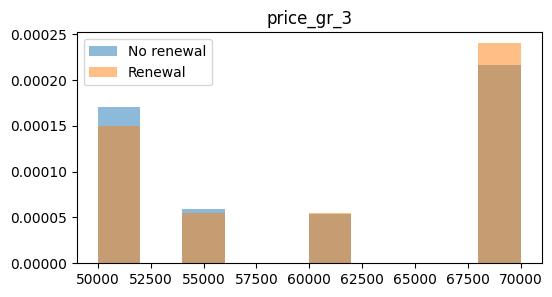

In [56]:
for feature in numeric_variables:
  plot_numeric_variable(train, feature)

In [57]:
for var in ['price_gr_3', 'price_prc']:
    train[var] = train[var].astype(float)

numeric_variables = (
    train.dtypes[train.dtypes != 'object']
    .drop(['ID', TARGET_NAME], axis=0)
    .index.tolist()
)

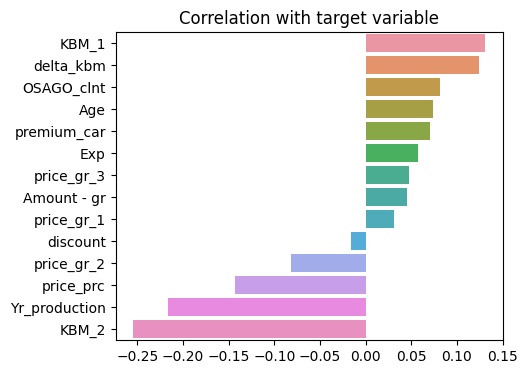

In [58]:
corr_with_target = (
    train[numeric_variables + [TARGET_NAME]]
    .corr()
    .iloc[:-1, -1]
    .sort_values(ascending=False)
)
plt.figure(figsize=(5, 4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

## 5. Категориальные переменные

In [59]:
categorical_variables = train.dtypes[train.dtypes == 'object'].index.tolist()
categorical_info = train[categorical_variables].describe().T
categorical_info

,count,unique,top,freq
Filial,7598,22,Московский,2313
Type_ts,7598,2,Иностранные,5845
passport_region,7598,85,Москва,1129
VIP,208,2,Особый статус +,154
Brand,7598,23,LADA,1512
Model,7598,190,RIO,657
GAP,7598,2,Нет,6818
married,7598,2,Состоит в браке,5950
deduct,7598,3,Без франшизы,5025
deduct_amount,7598,3,0,5025


### 5.1. Распределение категориальных признаков

In [60]:
def plot_categorical_variable(data, feature, figsize=(6, 3)):
  train = data.copy()
  train[feature] = train[feature].fillna('No data')
  train.loc[train[feature] == 0, feature] = 'Zero'

  var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
  var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

  plt.figure(figsize=figsize)
  plt.hist(var_target_0, density=True, alpha=0.5, label='No renewal')
  plt.hist(var_target_1, density=True, alpha=0.5, label='Renewal')
  plt.title(feature)
  plt.legend();

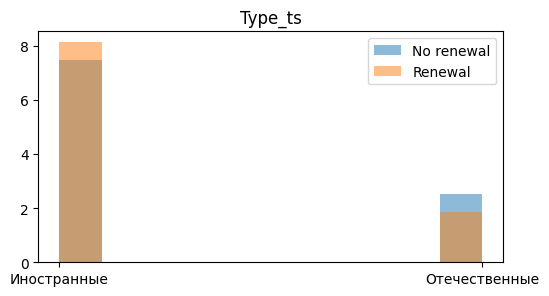

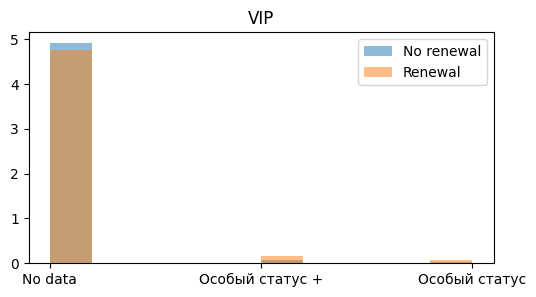

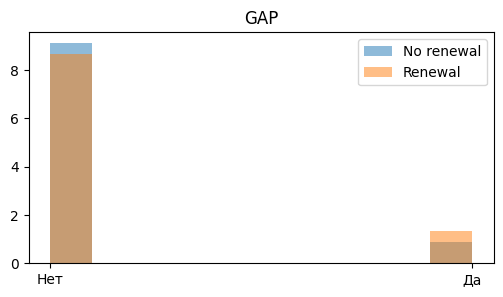

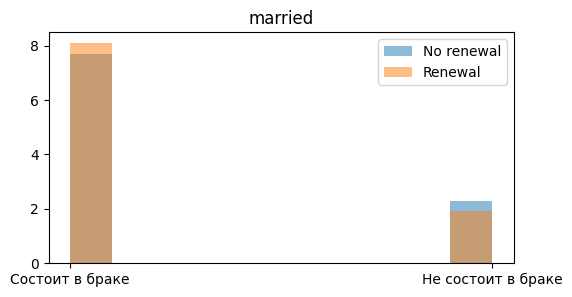

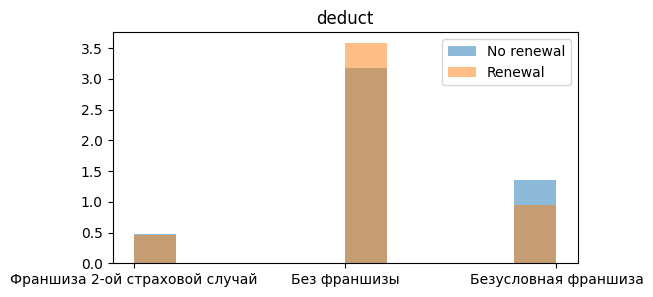

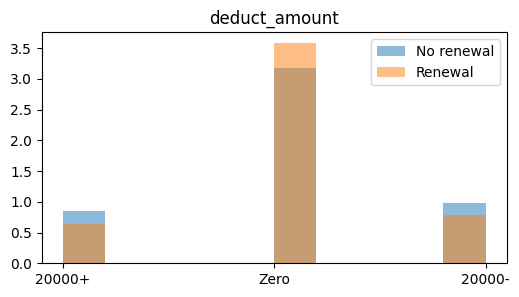

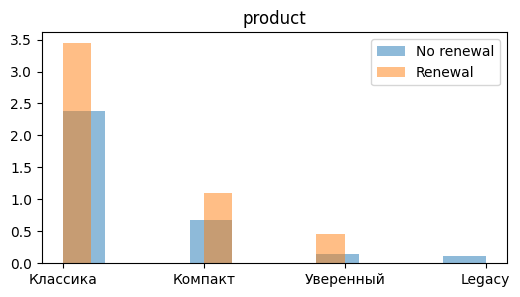

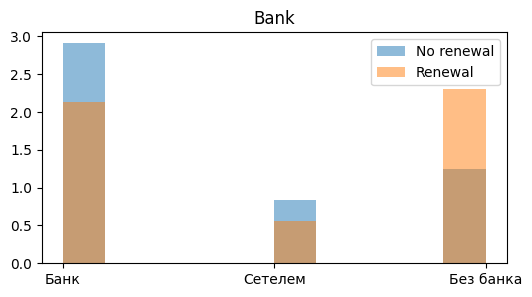

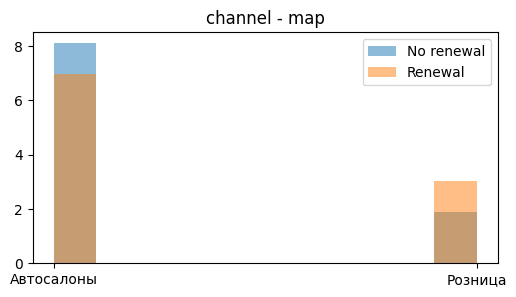

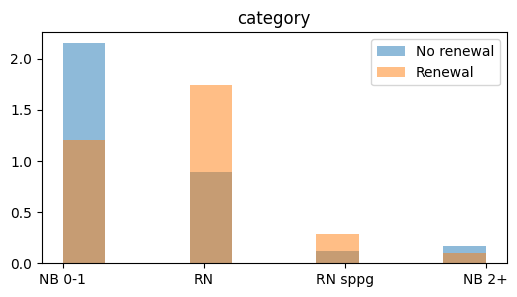

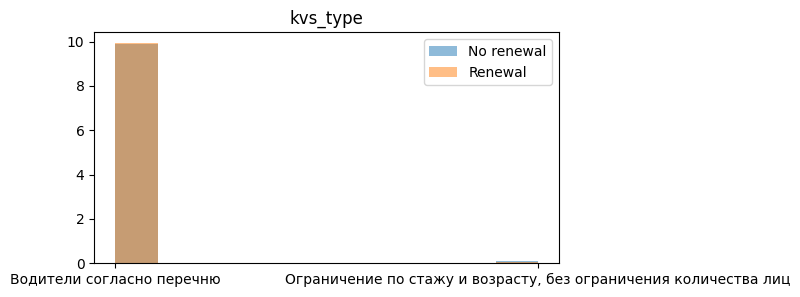

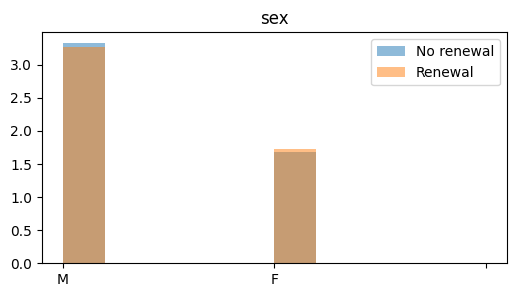

In [61]:
plot_list = categorical_info[categorical_info['unique'] < 10].index.tolist()
for feature in plot_list:
  plot_categorical_variable(train, feature)

### 5.2. Генерация новых категориальных признаков

#### sex_mariage

In [62]:
def merge_features(data, feature_1, feature_2, new_feature):
  data.loc[:, new_feature] = (
    data.loc[:, [feature_1, feature_2]]
    .apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
  )
  return data

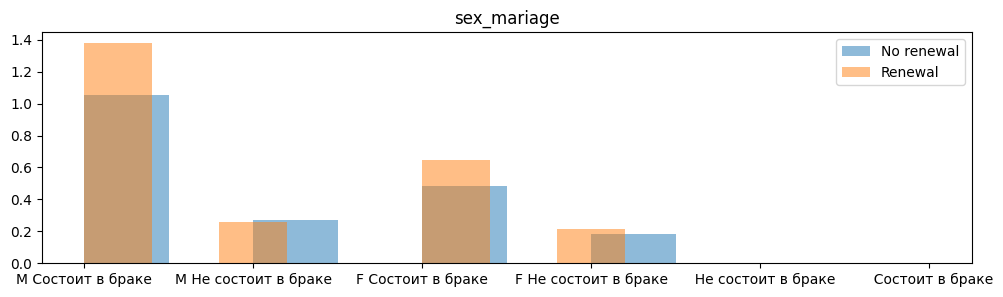

In [63]:
feature_1 = 'sex'
feature_2 = 'married'
new_feature = 'sex_mariage'

train = merge_features(train, feature_1, feature_2, new_feature)
plot_categorical_variable(train, new_feature, figsize=(12,3))

In [64]:
train.drop(['married', 'sex'], axis=1, inplace=True)

#### diff_passport_region

Несовпадение филиала продажи и региона по серии паспорта

In [65]:
def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1

  return data.drop(['passport_region', 'merged'], axis=1)

In [66]:
same_regions_list = get_same_regions_list(train)
train = get_diff_passport_region_feature(train, same_regions_list)

In [67]:
same_regions_list

['Московский Москва',
 'Московский Московская область',
 'Краснодарский Краснодарский край',
 'Санкт - Петербургский Санкт-Петербург',
 'Ростовский Ростовская область',
 'Казанский Республика Татарстан',
 'Воронежский Воронежская область',
 'Самарский Самарская область',
 'Пермский Пермский край',
 'Ижевский Удмуртская Республика',
 'Челябинский Челябинская область',
 'Нижегородский Нижегородская область',
 'Уфимский Республика Башкортостан',
 'Тверской Тверская область',
 'Екатеринбургский Свердловская область',
 'Волгоградский Волгоградская область',
 'Магнитогорский Челябинская область',
 'Ставропольский Ставропольский край',
 'Кемеровский Кемеровская область',
 'Белгородский Белгородская область',
 'Новосибирский Новосибирская область',
 'Санкт - Петербургский Ленинградская область',
 'Тульский Тульская область',
 'Дальневосточный Приморский край']

In [68]:
train.groupby('diff_passport_region').mean()[TARGET_NAME]

diff_passport_region
0    0.259063
1    0.323398
Name: target, dtype: float64

In [69]:
train['diff_passport_region'].value_counts()

1    6274
0    1324
Name: diff_passport_region, dtype: int64

* Филиал продажи и регион по серии паспорта содержат похожую информацию, из двух признаков оставим только филиал продажи - он лучше обобщается.
* Введем новый бинарный признак: несоответствие/соответствие филиала продажи региону по серии паспорта

### 5.3.Tрансформация категориальных признаков

#### CountEncoder

In [70]:
categorical_variables = train.dtypes[train.dtypes == 'object'].index.tolist()
categorical_variables

['Filial',
 'Type_ts',
 'VIP',
 'Brand',
 'Model',
 'GAP',
 'deduct',
 'deduct_amount',
 'product',
 'Bank',
 'channel - map',
 'category',
 'kvs_type',
 'sex_mariage']

In [71]:
count_encoder = ce.CountEncoder(cols=categorical_variables, normalize=True)
df = count_encoder.fit_transform(train)[categorical_variables]

count_variabls = [f'{col}_count' for col in categorical_variables]
df.columns = count_variabls

#### GLMMEncoder

In [72]:
glmm_encoder = ce.glmm.GLMMEncoder(
    cols=[
        'Filial',
        'Brand',
        'Model',
        'product',
        'Bank',
        'category',
        'sex_mariage',
    ]
)
train = glmm_encoder.fit_transform(train, y=train[TARGET_NAME])

### 5.4. Отбор признаков

In [73]:
train = pd.concat([train, df], axis=1)
train.fillna(0, inplace=True)

In [74]:
drop_features_cat = train.dtypes[train.dtypes == 'object'].index.tolist()
train.drop(drop_features_cat, axis=1, inplace=True)

In [75]:
vars = train.columns.tolist()
get_correlated_features(train, vars, 0.8)

-0.89 Brand Brand_count
0.98 deduct_count deduct_amount_count


In [76]:
drop_features = ['Brand_count', 'deduct_amount_count']
train.drop(drop_features, axis=1, inplace=True)

## 6. Визуализация данных с помощью T-SNE проекций

In [77]:
cols = [i for i in train.columns if not i in ['ID', TARGET_NAME]]

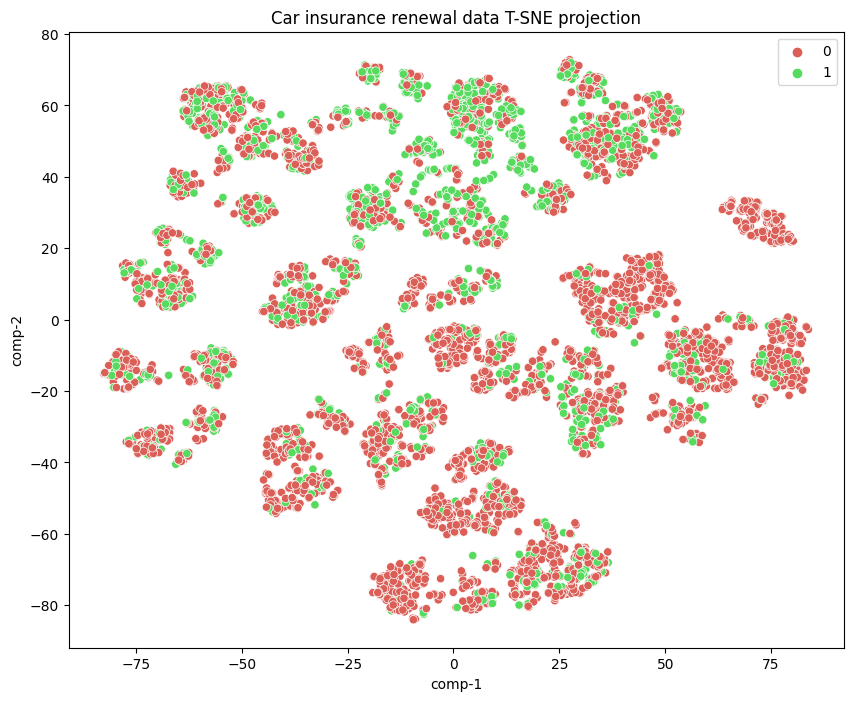

In [83]:
X_embedded = TSNE(
    n_components=2, learning_rate='auto', init='pca', random_state=42
).fit_transform(train[cols])

df = pd.DataFrame()
df[TARGET_NAME] = train[TARGET_NAME]
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="comp-1", y="comp-2", hue=df[TARGET_NAME].tolist(),
    palette=sns.color_palette("hls", 3),
    data=df).set(title="Car insurance renewal data T-SNE projection"
);

* Визуально можно предположить, что данные обучающей выборки могут быль линейно разделимыми.

## 7. Сравнение распределения переменных обучающей и тестовой выбоки.

In [79]:
def data_preparation_pipeline(train):
  train, vars_to_scale = generate_numeric_features(train)
  scaler = MinMaxScaler()
  train[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])

  count_vars = [
    'Filial',
    'Type_ts',
    'VIP',
    'Model',
    'GAP',
    'deduct_amount',
    'product',
    'Bank',
    'channel - map',
    'category',
    'kvs_type',
    'sex'
]
  count_encoder = ce.CountEncoder(cols=count_vars, normalize=True)
  df = count_encoder.fit_transform(train)[count_vars]
  df.columns = [f'{col}_count' for col in count_vars]

  train = generate_categorical_features(train)
  same_regions_list = get_same_regions_list(train)
  train = get_diff_passport_region_feature(train, same_regions_list)

  glmm_encoder = ce.glmm.GLMMEncoder(
      cols=[
          'Filial',
          'Brand',
          'Model',
          'product',
          'Bank',
          'category',
          'sex_mariage',
      ]
  )
  train = glmm_encoder.fit_transform(train, y=train[TARGET_NAME])

  train = pd.concat([train, df], axis=1)
  train.fillna(0, inplace=True)
  train['intercept'] = 1

  keys = ['scaler', 'same_regions_list', 'count_encoder', 'count_vars', 'glmm_encoder']
  args = (scaler, same_regions_list, count_encoder, count_vars, glmm_encoder)
  params = {}
  for i, key in enumerate(keys):
    params[key] = args[i]

  return train, params


def data_preparation_pipeline_inference(
    test, scaler, same_regions_list, count_encoder, count_vars, glmm_encoder
):
  test, vars_to_scale = generate_numeric_features(test)
  test[vars_to_scale] = scaler.transform(test[vars_to_scale])

  df = count_encoder.transform(test)[count_vars]
  df.columns = [f'{col}_count' for col in count_vars]

  test = generate_categorical_features(test)
  test = get_diff_passport_region_feature(test, same_regions_list)
  test = glmm_encoder.transform(test)
  test = pd.concat([test, df], axis=1)
  test.fillna(0, inplace=True)
  test['intercept'] = 1

  return test


def generate_numeric_features(train):
  train['KBM_1'] = np.where(train['KBM'] <= 3, train['KBM'], 0)

  train['delta_kbm'] = np.where(train['delta_kbm'] < 0, train['delta_kbm'], 0)
  train['delta_kbm'] = np.where(train['delta_kbm'] == -100, 3, train['delta_kbm'])

  train['Age'] = np.where(train['Age'] <= 27, 27, train['Age'])
  train['Age'] = np.where(train['Age'] >= 65, 65, train['Age'])

  train['Exp'] = np.where(train['Exp'] >=45, 45,  train['Exp'])

  train['price_gr_1'] = np.where(train['price_gr'] < 1.5e4, 1, 0)
  train['price_gr_2'] = np.where(
      (train['price_gr'] >= 1.5e4) & (train['price_gr'] <= 4e4), train['price_gr'], 0
  )
  bins = [4e4,  5e4, 5.5e4, 6e4, 7e4]
  train['price_gr_3'] = pd.cut(train['price_gr'], bins, labels=bins[1:])

  train['price_prc'] = np.where(
      train['price_prc'] <= 0.005, 0.005, train['price_prc']
  )
  train['price_prc'] = np.where(
      train['price_prc'] >= 0.075, 0.075, train['price_prc']
  )
  bins = [
      0, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.075
  ]
  train['price_prc'] = pd.cut(train['price_prc'], bins, labels=bins[1:])

  for var in ['price_gr_3', 'price_prc']:
    train[var] = train[var].astype(float)

  drop_features = ['KBM', 'KBM_prol_est', 'price_gr']
  vars_to_scale = [
      'Yr_production',
      'KBM_1',
      'delta_kbm',
      'Age',
      'Exp',
      'discount',
      'Amount - gr',
      'price_gr_2',
      'price_gr_3',
      'price_prc',
  ]

  return train.drop(drop_features, axis=1), vars_to_scale


def generate_categorical_features(data):
  data = merge_features(data, 'sex', 'married', 'sex_mariage')
  drop_features = [
      'Type_ts',
      'VIP',
      'GAP',
      'married',
      'deduct',
      'deduct_amount',
      'channel - map',
      'kvs_type',
      'sex'
  ]

  return data.drop(drop_features, axis=1)


def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1

  return data.drop(['passport_region', 'merged'], axis=1)


def merge_features(data, feature_1, feature_2, new_feature):
  data.loc[:, new_feature] = (
    data.loc[:, [feature_1, feature_2]]
    .apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
  )

  return data

In [80]:
def plot_train_test_distributions(group):
    fig, axes = plt.subplots(9, 4, figsize=(25, 32))

    for num, feature in enumerate(group):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")

In [81]:
train = data[data[TARGET_NAME] != -1]
test = data[data[TARGET_NAME] == -1]

train, params = data_preparation_pipeline(train)
test = data_preparation_pipeline_inference(test, **params)

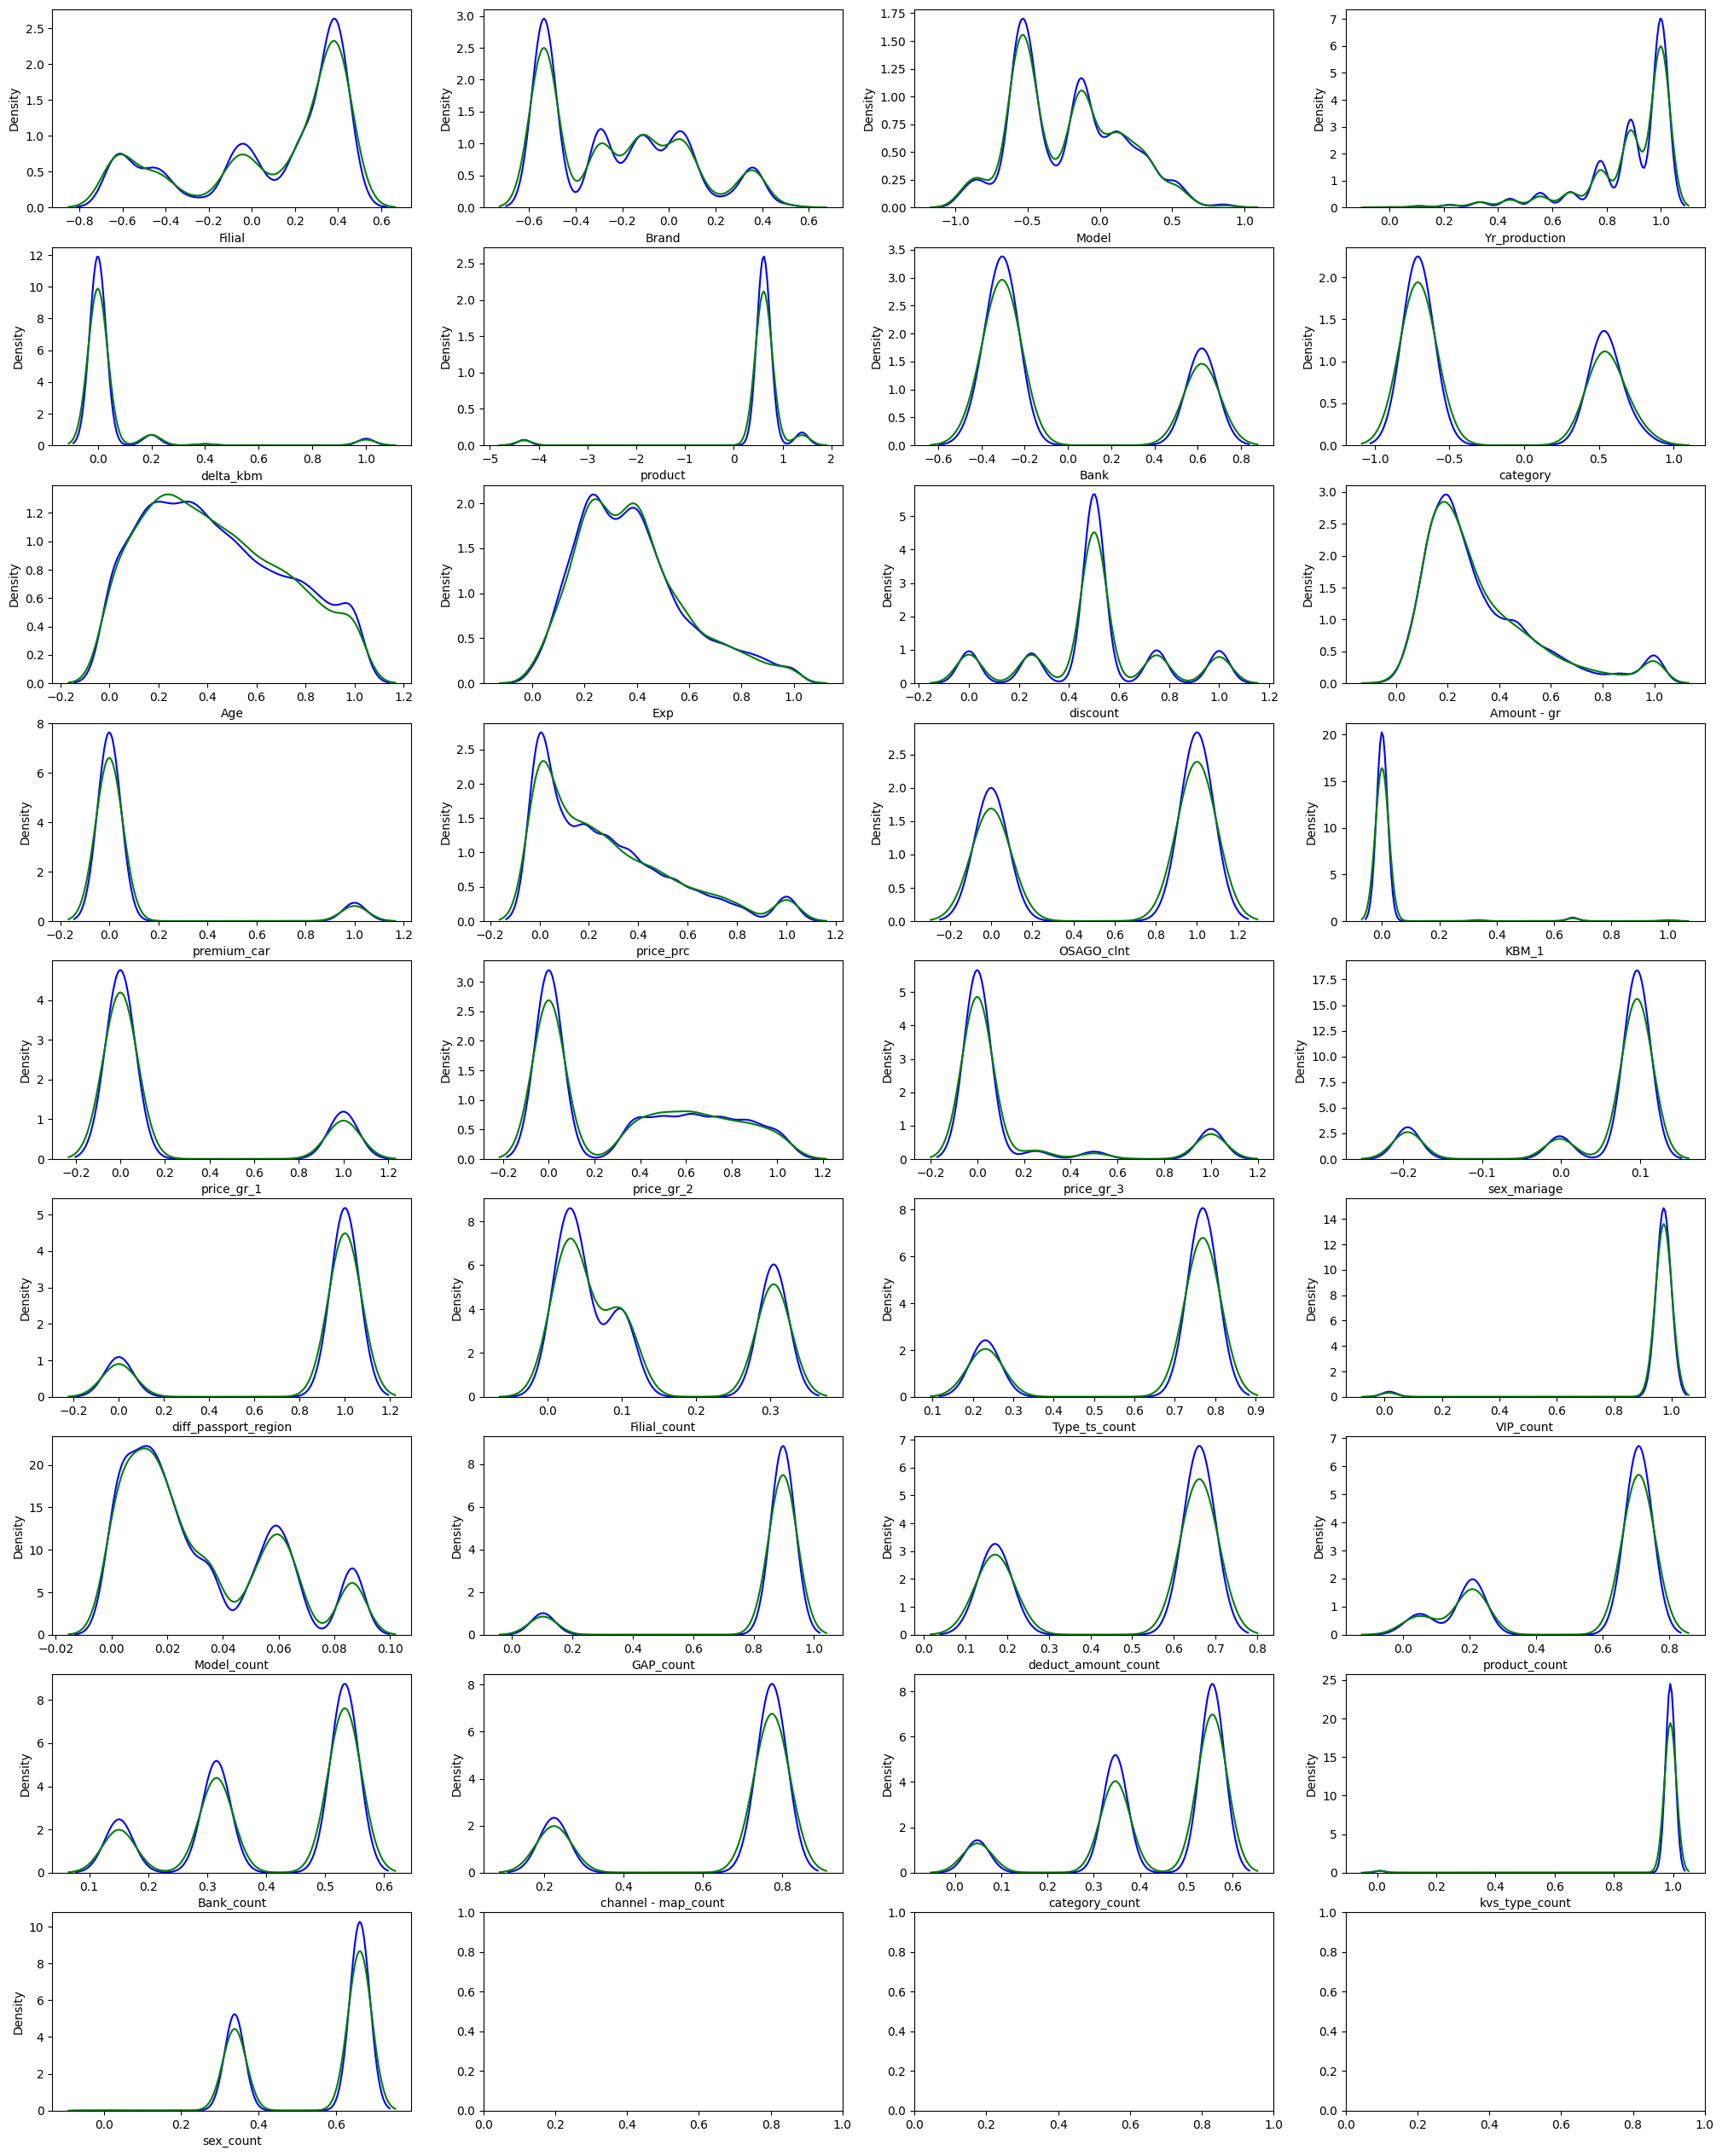

In [82]:
cols = [i for i in train.columns if not i in ['ID', TARGET_NAME, 'intercept']]
plot_train_test_distributions(cols)

* Распределения переменных обучающей и тестовой выборки, в целом, похожи.